In [34]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import pickle
import warnings
warnings.filterwarnings("ignore")

The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.

Na_to_K refers to the sodium-to-potassium ratio in a patient's blood. This ratio is a measure of the relative concentration of sodium (Na) to potassium (K) in the body and is often used in medical assessments to evaluate electrolyte balance and overall health.

In [2]:
drug = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv", delimiter=",")
drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [3]:
drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [4]:
drug.Drug.value_counts()

,count
Drug,
drugY,91
drugX,54
drugA,23
drugC,16
drugB,16


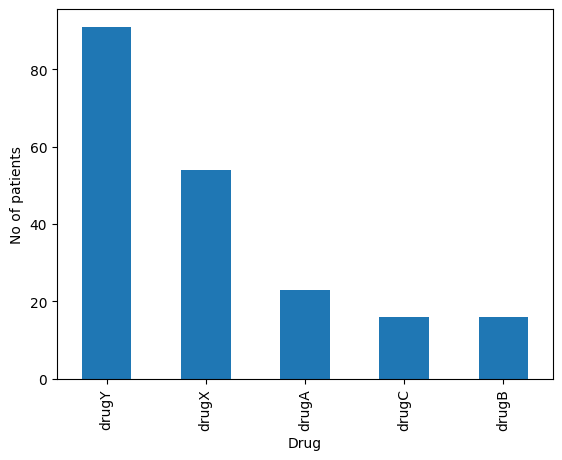

In [5]:
ax= drug.Drug.value_counts().plot.bar()
ax.set(xlabel='Drug', ylabel= 'No of patients')
plt.show()


In [6]:
nunique= drug.nunique()
nunique

,0
Age,57
Sex,2
BP,3
Cholesterol,2
Na_to_K,198
Drug,5


In [7]:
categorical_variables= list(nunique[nunique <=5].index)
categorical_variables

['Sex', 'BP', 'Cholesterol', 'Drug']

In [8]:
continuous_variables= list(set(drug.columns) - set(categorical_variables))
continuous_variables

['Na_to_K', 'Age']

In [9]:
drug.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

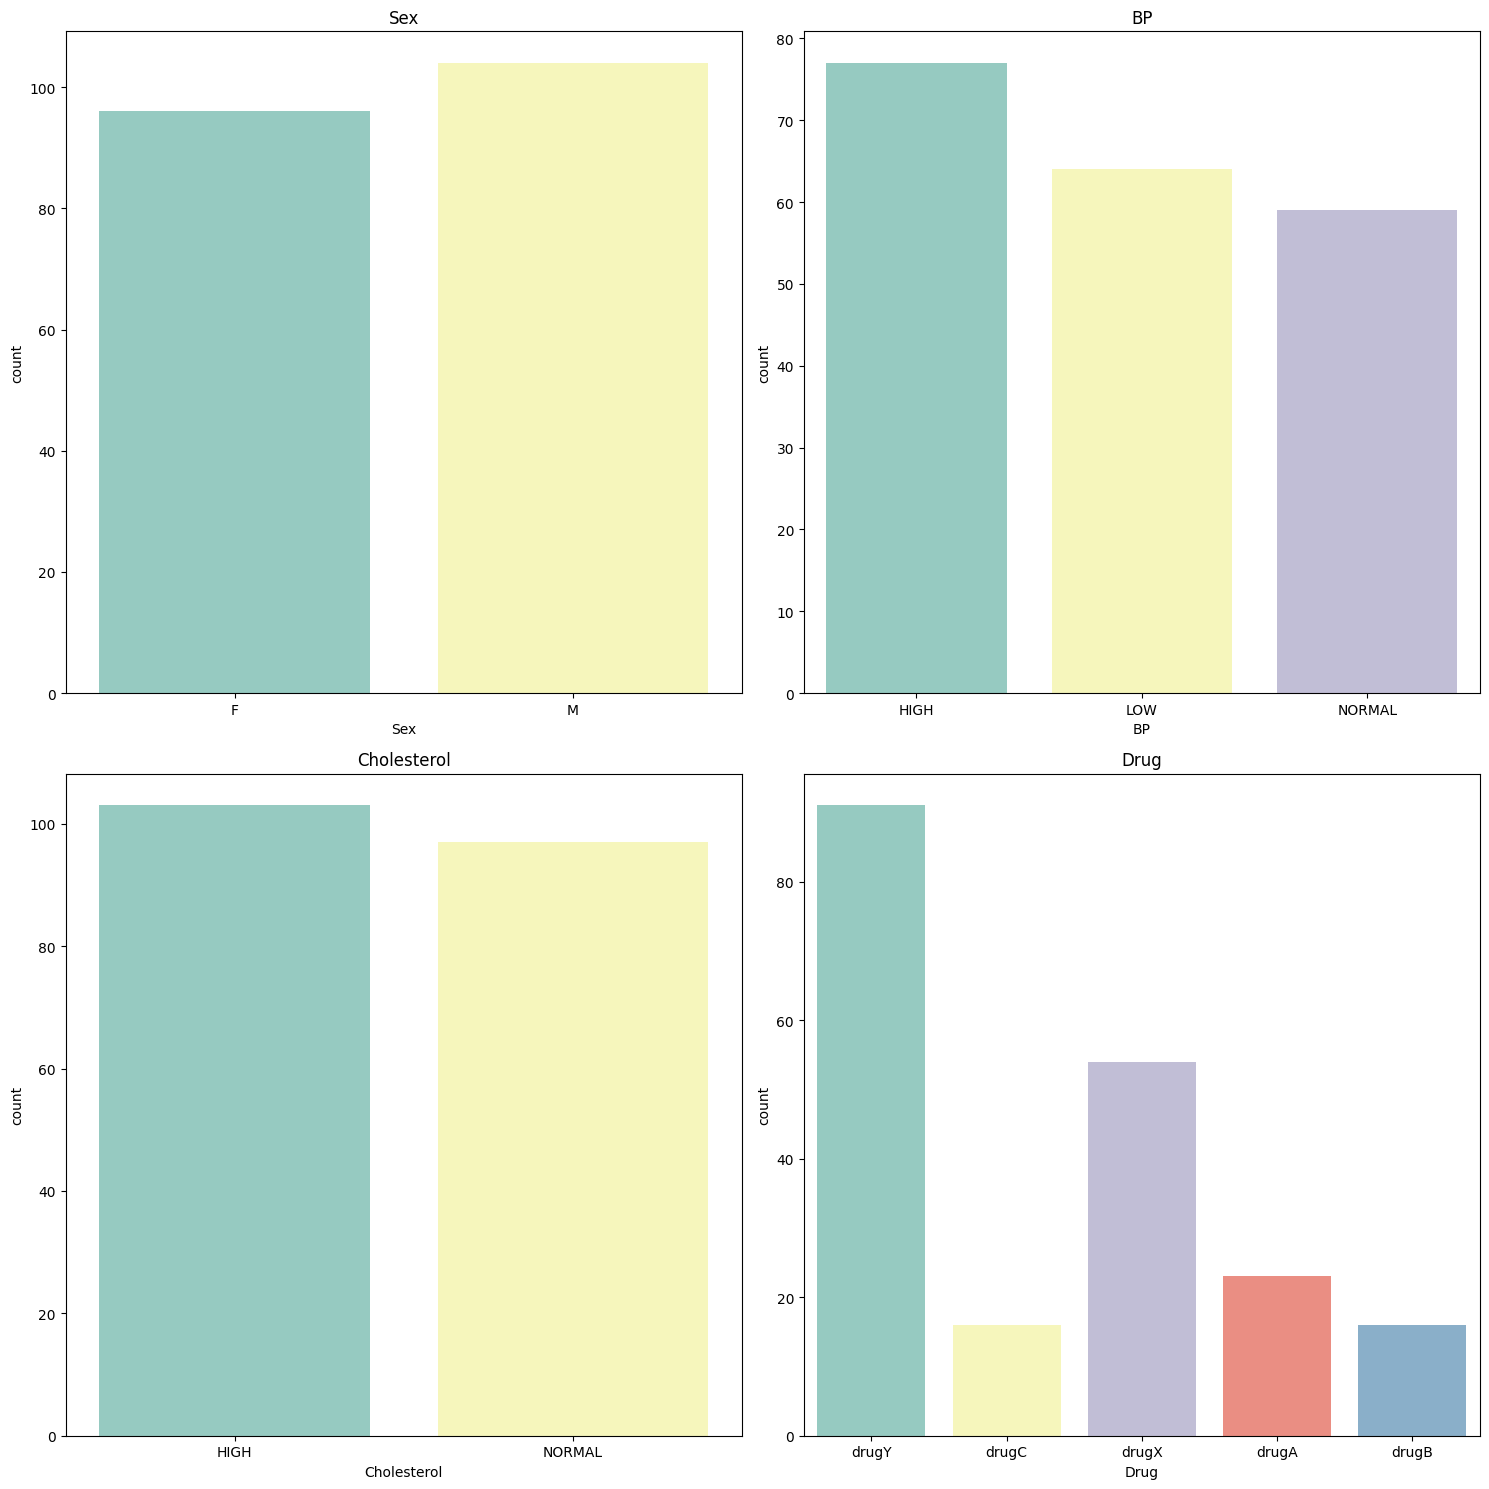

In [10]:
plt.figure(figsize= (15, 15))
for i, column in enumerate(categorical_variables, 1):
  plt.subplot(2, 2, i)
  sns.countplot(x=drug[column], palette= 'Set3')
  plt.title(column)
  plt.tight_layout()
plt.show()

In [11]:
lb= LabelEncoder()

for column in categorical_variables:
  drug[column]= lb.fit_transform(drug[column])

In [12]:
drug[categorical_variables][:5]

,Sex,BP,Cholesterol,Drug
0,0,0,0,4
1,1,1,0,2
2,1,1,0,2
3,0,2,0,3
4,0,1,0,4


In [13]:
sc= StandardScaler()
drug[continuous_variables]= sc.fit_transform(drug[continuous_variables])
drug[continuous_variables][:5]

,Na_to_K,Age
0,1.286522,-1.291591
1,-0.415145,0.162699
2,-0.828558,0.162699
3,-1.149963,-0.988614
4,0.271794,1.011034


In [14]:
X, y= drug.drop('Drug', axis='columns'), drug['Drug']

In [15]:
X.shape, y.shape

((200, 5), (200,))

In [16]:
# Split train and test set

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=234)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 5), (40, 5), (160,), (40,))

In [18]:
y.value_counts()

,count
Drug,
4,91
3,54
0,23
2,16
1,16


In [19]:
drug[:5]

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,-1.291591,0,0,0,1.286522,4
1,0.162699,1,1,0,-0.415145,2
2,0.162699,1,1,0,-0.828558,2
3,-0.988614,0,2,0,-1.149963,3
4,1.011034,0,1,0,0.271794,4


In [20]:
smote= SMOTE()
X_sm, y_sm= smote.fit_resample(X_train, y_train)

In [21]:
y_sm.value_counts()

,count
Drug,
3,73
2,73
4,73
1,73
0,73


In [22]:
X_sm

,Age,Sex,BP,Cholesterol,Na_to_K
0,0.889843,0,2,0,-0.305374
1,0.283889,1,1,0,-0.769856
2,-0.140278,1,1,0,0.545182
3,-1.352186,0,0,1,0.934448
4,-1.291591,1,2,0,2.165111
...,...,...,...,...,...
360,-0.598396,0,1,1,-0.484474
361,1.429815,0,1,1,-0.555041
362,-0.424822,1,1,1,-0.882689
363,-0.727549,0,2,0,-1.180464


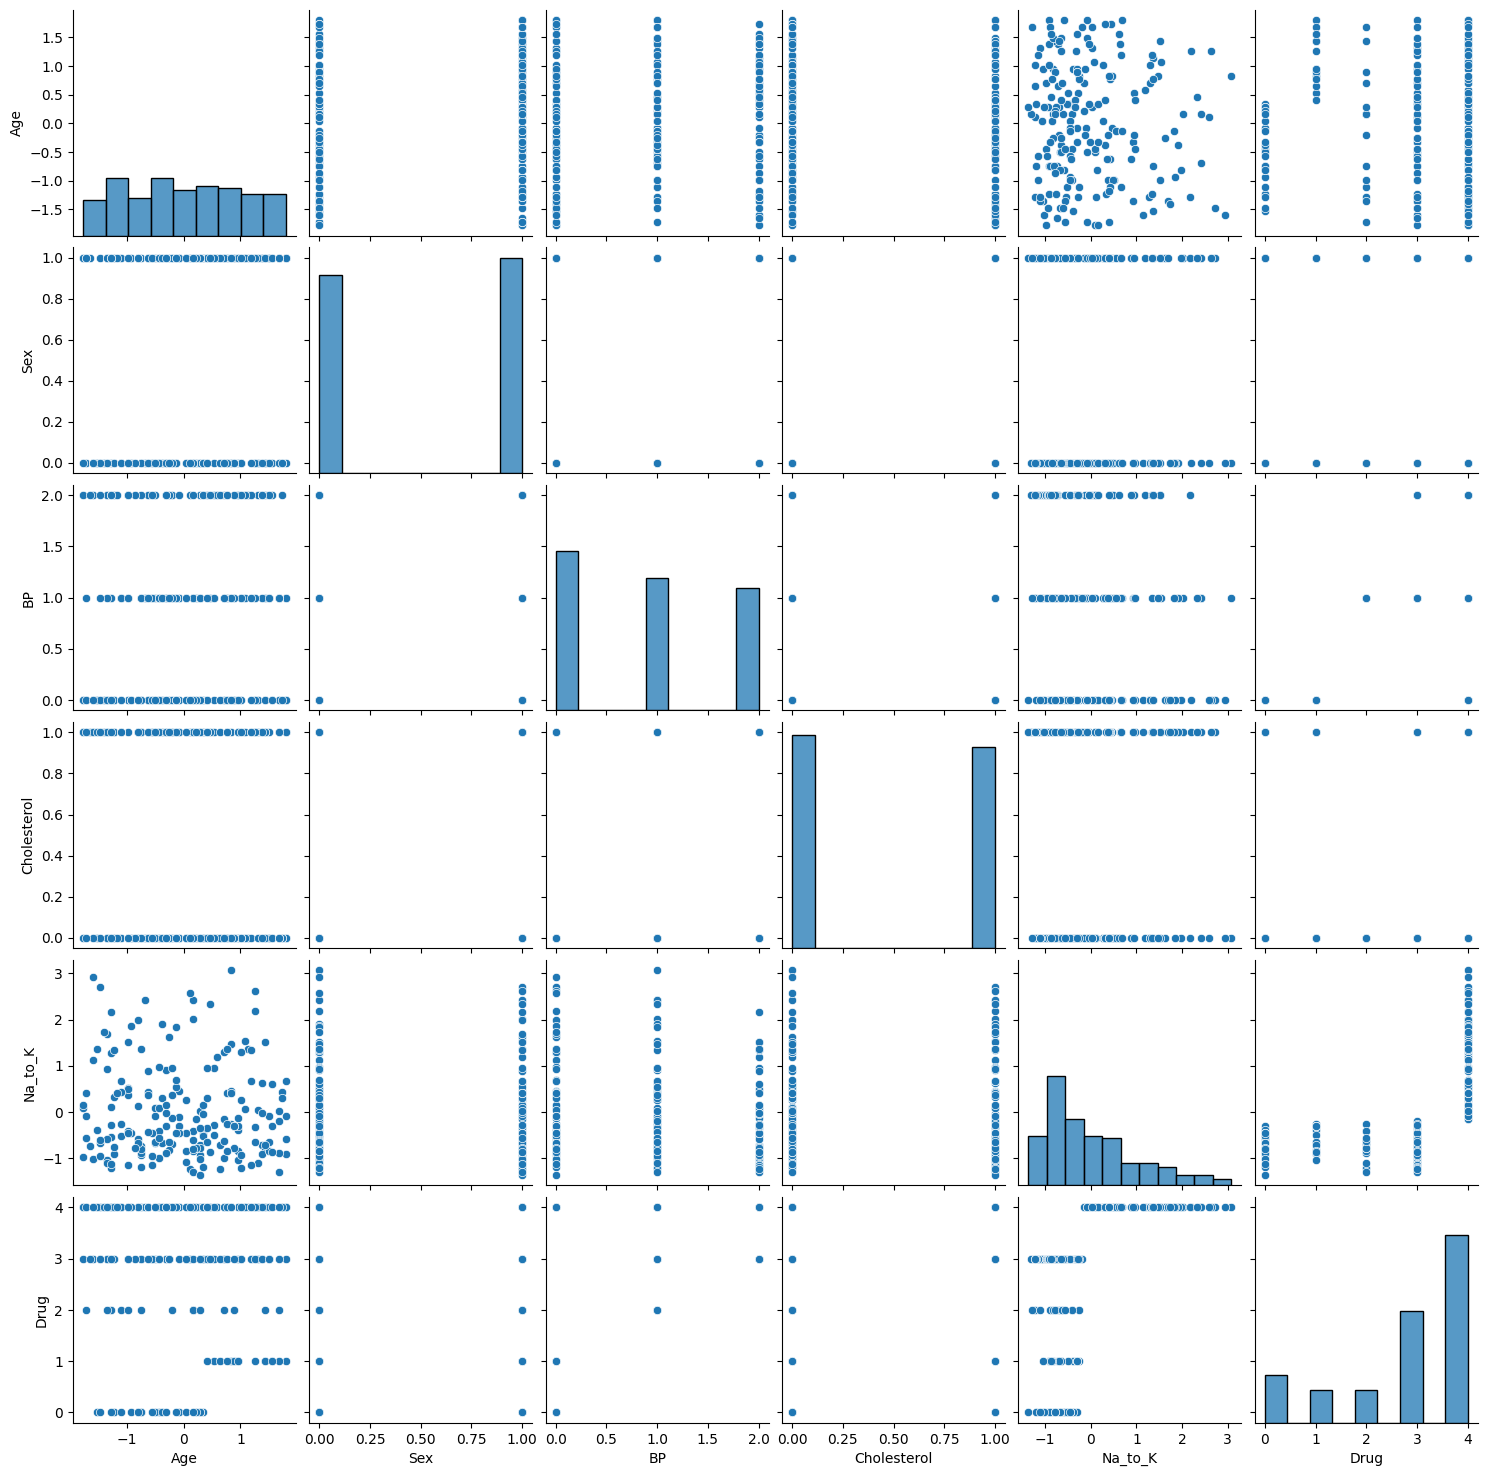

In [23]:
sns.pairplot(drug)
plt.show()

## **Model Building**

### **Random Forest Classifier**

In [24]:
# Training and test accuracy check and comparism
def get_accuracy(X_train, X_test, y_train, y_test, model):
  print({"Test Accuracy": accuracy_score(y_test, model.predict(X_test)),
         "Train Accuracy": accuracy_score(y_train, model.predict(X_train))})


In [25]:
# standard random forest classification
rf= RandomForestClassifier(random_state= 234)
rf.fit(X_sm, y_sm)
y_pred= rf.predict(X_test)

In [26]:
get_accuracy(X_sm, X_test, y_sm, y_test, rf)

{'Test Accuracy': 1.0, 'Train Accuracy': 1.0}


In [27]:
# Tuning random forest to reduce overfitting
rf= RandomForestClassifier()
param_grid= {'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
             "max_depth": [4, 6, 7, 9, 10, 11, 13, 15, 17, 19],
             "max_features": ['auto', 'sqrt', 'log2'],
             "bootstrap": [True, False]}

rf_search= GridSearchCV(estimator=rf,
                      param_grid= param_grid,
                      scoring= 'accuracy',
                      cv=5)
rf_search.fit(X_sm, y_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [4, 6, 7, 9, 10, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160,
                                          180, 200]},
             scoring='accuracy')

In [28]:
get_accuracy(X_sm, X_test, y_sm, y_test, rf_search.best_estimator_)

{'Test Accuracy': 1.0, 'Train Accuracy': 1.0}


In [29]:
rf_search.best_score_

1.0

In [30]:
rf_search.best_params_

{'bootstrap': True, 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 40}

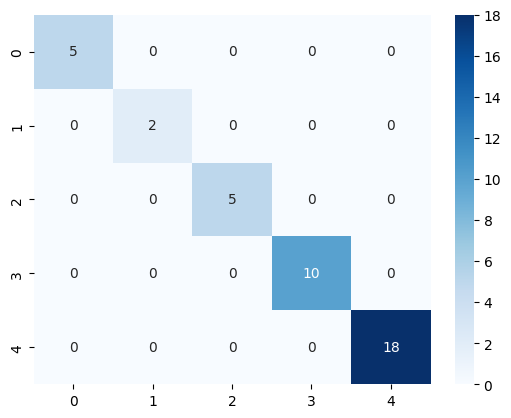

In [31]:
y_pred= rf_search.predict(X_test)
cm= confusion_matrix(y_test, y_pred)
ax= sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        18

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



### **Logistic Regression**

In [35]:
log= LogisticRegression()
log.fit(X_sm, y_sm)
get_accuracy(X_sm, X_test, y_sm, y_test, log)

{'Test Accuracy': 0.9, 'Train Accuracy': 0.9808219178082191}


In [36]:
l_lib= LogisticRegression(solver= 'liblinear')
l_lib.fit(X_sm, y_sm)
get_accuracy(X_sm, X_test, y_sm, y_test, l_lib)

{'Test Accuracy': 0.9, 'Train Accuracy': 0.9726027397260274}


In [43]:
# Tuning logistic regression
lr_l1= LogisticRegressionCV(Cs= 10, cv=5, penalty='l1', solver='liblinear').fit(X_sm, y_sm)
get_accuracy(X_sm, X_test, y_sm, y_test, lr_l1)

{'Test Accuracy': 1.0, 'Train Accuracy': 0.9726027397260274}


In [40]:
lr_l2= LogisticRegressionCV(Cs= 10, cv=5, penalty='l2', solver='liblinear').fit(X_sm, y_sm)
get_accuracy(X_sm, X_test, y_sm, y_test, lr_l2)

{'Test Accuracy': 1.0, 'Train Accuracy': 0.9643835616438357}


In [44]:
l2_pred= lr_l2.predict(X_test)
print(classification_report(l2_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        18

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [46]:
import  pickle

# Save the model
pickle.dump(l2_pred, (open('drug_pred.p', 'wb')))